In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import cython
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle
import skopt

In [2]:
g_ket = basis(5,0)
u_ket = basis(5,1)
x_ket = basis(5,2)
a_ket = basis(5,3)
b_ket = basis(5,4)

g_bra = g_ket.dag()
u_bra = u_ket.dag()
x_bra = x_ket.dag()
a_bra = a_ket.dag()
b_bra = b_ket.dag()

g_id = g_ket*g_bra
u_id = u_ket*u_bra
x_id = x_ket*x_bra
a_id = a_ket*a_bra
b_id = b_ket*b_bra

gx_swap = x_ket*g_bra
ux_swap = x_ket*u_bra

spont_decay = b_ket*x_bra
cav_decay = a_ket*g_bra

In [3]:
H_cav = -(gx_swap + gx_swap.dag())
H_rabi = -1/2*(ux_swap + ux_swap.dag())
H_atom = u_id + g_id

In [4]:
gamma = 2*np.pi
pulse_time = 10/gamma
STEPS_PER_SEC = 1000

H_args = {
    'T': 10/gamma,
    'wSTIRAP': np.pi/pulse_time
    }
H_ops = Options(rhs_reuse=True, nsteps=10000)

def create_time(pulse_time, kappa):
    num_steps1 = round(STEPS_PER_SEC*pulse_time + 1)
    if num_steps1 < 1001:
        num_steps1 = 1001
        
    t_res = 2
    int_time1 = round(pulse_time, t_res)*10**t_res
    t1 = np.linspace(0, int_time1, num_steps1)
    t1 /= 10**t_res

    if kappa > 1:
        added_time = 1/gamma
    else:
        added_time = gamma/kappa

    num_steps2 = round(STEPS_PER_SEC*added_time + 1)
    if num_steps2 < 1001:
        num_steps2 = 1001
    t_res = 2
    int_time2 = round(pulse_time + added_time, t_res)*10**t_res
    t2 = np.linspace(t1[-1], int_time2, num_steps1)
    t2 /= 10**t_res

    return [t1, t2]

sin_pulse = 'sin'
tophat_pulse = 'tophat'
opts = Options(rhs_reuse=True)

In [5]:
def save_obj(object, name):
    with open(name+'.pickle', 'wb') as f:
        print(name+'.pickle')
        pickle.dump(object, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [6]:
NUM_GS = 25
NUM_KAPPAS = 20
kappa_min = 2
kappa_max = 30
g_min = 40
g_max = 120

kappas = np.logspace(np.log10(kappa_min), np.log10(kappa_max), NUM_KAPPAS)
g_ratios = np.logspace(np.log10(g_min), np.log10(g_max), NUM_GS)
current_kappa = kappas[0]

In [7]:
def find_efficiency(g_ratio, omega, delta, kappa, pulse_time, psi0=u_ket, pulse_shape=sin_pulse):

    omega *= 2*np.pi
    delta *= 2*np.pi
    g0 = g_ratio*gamma

    H_args['omega'], H_args['delta'], H_args['g0'] = omega, delta, g0
    t1, t2 = create_time(pulse_time, kappa)

    global current_kappa
    if kappa != current_kappa:
        opts.rhs_reuse = False
        current_kappa = kappa

    c_ops = [np.sqrt(kappa*gamma/2)*cav_decay, np.sqrt(gamma/2)*spont_decay]

    if pulse_shape =='sin':
        pulse = 'omega*np.sin(wSTIRAP*t)**2'
    else:
        pulse = 'omega'

    H = [[H_cav, 'g0'], [H_rabi, pulse], [H_atom, 'delta']]

    result1 = mesolve(H, psi0, t1, c_ops, options=opts, args=H_args)
    H_args['omega'] = 0
    result2 = mesolve(H, result1.states[-1], t2, c_ops, options=opts, args=H_args)
    opts.rhs_reuse = True

    return expect(a_id, result2.states[-1])
    

In [8]:
for i in range(1):

    def iterative_optimiser_2D(inputs):
        
        g_ratio, omega_0, delta_0, kappa= inputs

        omg_res = [ 300, 100, 30, 10, 3, 1, 0.3, 0.1]
        delt_res = [1000, 300, 100, 30, 10, 3, 1, 0.3, 0.1]

        initial_eff = find_efficiency(g_ratio, omega_0, delta_0, kappa, pulse_time=pulse_time, psi0=u_ket, pulse_shape=sin_pulse)
    
        def find_eff(omega,delta):
            return find_efficiency(g_ratio, omega, delta, kappa, pulse_time)
        
        for res in omg_res:
            # print(f'res = {res}')
            

            finished = False
            new_step = 0
            

            while not finished:
                print(omega_0, delta_0, initial_eff)


                if new_step == 0:
                    temp_effs = [initial_eff, find_eff(omega_0-res, delta_0), find_eff(omega_0 + res, delta_0)]
                elif new_step == 1:
                    temp_effs = [initial_eff, temp_effs[0],find_eff(omega_0+res, delta_0)]
                else:
                    temp_effs = [initial_eff, find_eff(omega_0-res,delta_0), temp_effs[0]]
                
                initial_eff = max(temp_effs)
                if np.argmax(temp_effs) == 0:
                    
                    finished = True
                elif np.argmax(temp_effs) == 1:
                    new_step = -1
                    omega_0 -= res
                else:
                    new_step = 1
                    omega_0 += res

        omega_0 = abs(omega_0)
        

        '''
        for res in delt_res:
            # print(f'res = {res}')
            

            finished = False
            new_step = 0
            

            while not finished:
                # print(omega_0, delta_0, initial_eff)


                if new_step == 0:
                    temp_effs = [initial_eff, find_eff(omega_0, delta_0-res), find_eff(omega_0, delta_0+res)]
                elif new_step == 1:
                    temp_effs = [initial_eff, temp_effs[0],find_eff(omega_0, delta_0+res)]
                else:
                    temp_effs = [initial_eff, find_eff(omega_0,delta_0-res), temp_effs[0]]
                
                initial_eff = max(temp_effs)
                if np.argmax(temp_effs) == 0:
                    
                    finished = True
                elif np.argmax(temp_effs) == 1:
                    new_step = -1
                    delta_0 -= res
                else:
                    new_step = 1
                    delta_0 += res

        delta_0 = abs(delta_0)
        '''

        def neg_eff(omg_del):
            return -find_eff(omg_del[0],0)
        op_result = skopt.gp_minimize(neg_eff, [[omega_0*0.95, omega_0*1.05]],x0=[omega_0], n_calls=12)
        omega_0 = op_result.x[0]
        initial_eff = -op_result.fun
                        
        return {
            'g_ratio': g_ratio,
            'kappa_ratio': kappa,
            'omega': np.abs(omega_0),
            'delta': np.abs(delta_0),
            'efficiency': initial_eff
        }

In [9]:
total_cores = multiprocessing.cpu_count()
if total_cores > 60:
    num_cores = 60
else:
    num_cores = total_cores

In [10]:
first_time = True
input_args = []
output_list = []
for j in range(len(kappas)):
    input_args.append([[g_ratios[k], 100, 0, kappas[j]] for k in range(len(g_ratios))])

for input_set in input_args:

    if not first_time:
        for k in range(len(g_ratios)):
            input_set[k][1] = processed_list['omega']
            #input_set[k][2] = processed_list['delta']

    if __name__ == "__main__":
        inputs = tqdm(input_set)
        processed_list = Parallel(n_jobs=num_cores)(delayed(iterative_optimiser_2D)(i) for i in inputs)
        output_list.append(processed_list)
        save_obj(output_list, 'kappa_[2,30]g_[40,120] sin^2 time = 10gamma^-1')
    first_run = False

 44%|████▍     | 11/25 [00:00<00:00, 22.61it/s]

100 0 0.8764824518921801
100 0 0.9435482048175053
100 0 0.9353029448757265
100 0 0.9038312311044664
400 0 0.9974229343395672
100 0 0.8908355167250381
100 0 0.9259906707064628
400 0 0.9983965065205338
100 0 0.860731157341463
100 0 0.9155263787788029
700 0 0.9990210254193026
400 0 0.998288516540496
700 0 0.9991778581948751
400 0 0.9978451420643525
700 0 0.9991684384632268
1000 0 0.9993415970099594
1000 0 0.9993357600542414
400 0 0.9976490607296914
400 0 0.9981620578456135
400 0 0.998015168427144700 0 0.9991009525907983

400 0 0.9971631718443549
1000 0 0.9993486850181842
700 0 0.9990647979619607
1300 0 0.9994602656742999
700 0 0.9991525561403813
1300 0 0.9993852235842023
700 0 0.9991301032364024
1000 0 0.9993582392948385
700 0 0.9989693491110015
1000 0 0.9993521722760735
1300 0 0.999408801066879
1000 0 0.9993566117693986
1600 0 0.9995163001700889
1600 0 0.9993996345697165
1000 0 0.9993596543112973
1000 0 0.99932654111344
1300 0 0.9994518453571203
1300 0 0.9994579649478063
1600 0 0.9994302

 44%|████▍     | 11/25 [00:20<00:00, 22.61it/s]

2100 0 0.9994675817803494
1930 0 0.9994352901938944
2300 0 0.999497579910016
2800 0 0.9995518397501213
3100 0 0.999576327172835
3100 0 0.9995980596636264
2100 0 0.9994675817803494
1930 0 0.9994352901938944
2300 0 0.999497579910016
2600 0 0.9995256726151818
1720 0 0.9994006955296115
3400 0 0.9995991334222718
1720 0 0.9994006955296115
2800 0 0.9995518397501213
2600 0 0.9995256726151818
2100 0 0.9994675817803494
1930 0 0.9994352901938944
3100 0 0.999576327172835
2330 0 0.9994976333037731
3400 0 0.9995991334222718
1723 0 0.9994007259044797
1930 0 0.9994352901938944
2110 0 0.999467626235261
2330 0 0.9994976333037731
2600 0 0.9995256726151818
2830 0 0.999551898274826
1726 0 0.9994007456710942
2110 0 0.999467626235261
3130 0 0.9995763520042098
1726 0 0.9994007456710942
2830 0 0.999551898274826
1929 0 0.9994353312212785
3400 0 0.9995991334222718
2320 0 0.9994976702767063
3130 0 0.9995763520042098
2600 0 0.9995256726151818
2107 0 0.9994676334056377
1929 0 0.9994353312212785
2310 0 0.99949767248

 64%|██████▍   | 16/25 [00:29<00:24,  2.68s/it]

100 0 0.8435592944731444
400 0 0.9968642793992831
100 0 0.8249662241225818
3380 0 0.9995991796967065
700 0 0.9989091907640928
400 0 0.9965204941914546
1000 0 0.9993068656149289
700 0 0.9988393659491259
1300 0 0.9994542197466654
1000 0 0.999282405530497
1600 0 0.9995253072283714
1300 0 0.999445908695194
1600 0 0.9995252551335536
1900 0 0.9995647153310625
100 0 0.8049746640218137
400 0 0.9961248492691935
1900 0 0.9995695994299033
2200 0 0.9995880388013599
700 0 0.9987592206102683
1000 0 0.9992529887844076
2200 0 0.9995965024482216
2500 0 0.9996023444169112
1300 0 0.9994340784181935
2500 0 0.9996136036286472
2800 0 0.9996112383007567
1600 0 0.9995221396137294
1900 0 0.9995718420053237
2800 0 0.9996247081592768
3100 0 0.9996164478014943
2200 0 0.9996024458580317
3100 0 0.9996317923504764
3400 0 0.9996191281624708
2500 0 0.9996222540337024
100 0 0.7836313900566807
3400 0 0.9996362859340847
2800 0 0.99963553147924
100 0 0.7610076427077591
100 0 0.7371986283448004
400 0 0.9956692137401281
370

100%|██████████| 25/25 [00:56<00:00,  2.26s/it]

6500 0 0.9997078899321159


100 0 0.6599237929038201
5203 0 0.999676386067528
7300 0 0.9997351675313657
400 0 0.9920900901352397
5660 0 0.9996926155785073
700 0 0.9979787580792445
1000 0 0.9989493585738913
1300 0 0.9992837838788816
7300 0 0.9997220376761885
7600 0 0.9997353199795048
1600 0 0.9994425915920859
5203 0 0.999676386067528
6500 0 0.9997078899321159
1900 0 0.9995323169283461
7900 0 0.9997355234713712
5657 0 0.9996926310453512
2200 0 0.9995888555497952
5203.1 0 0.9996764496638881
2500 0 0.9996269289751807
7300 0 0.9997220376761885
5657 0 0.9996926310453512
6500 0 0.9997078899321159
7900 0 0.9997355234713712
2800 0 0.9996540954427007
100 0 0.6327200543004364
400 0 0.9910042410410591
3100 0 0.9996742414974056
700 0 0.997779097709814
1000 0 0.998871982902405
5658 0 0.99969264697473
3400 0 0.9996894776614288
1300 0 0.9992435145525134
6500 0 0.9997078899321159
7300 0 0.9997220376761885
1600 0 0.9994185262355308
7900 0 0.9997355234713712
5658 0 0.99969264697473
3700 0 0.9997013173603908
100 0 0.6050735427346566

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9103235997372982
100 0 0.8970166896624019
100 0 0.9421214450042041
400 0 0.9989011692901608
400 0 0.998787293110039
400 0 0.9991425666159327
700 0 0.9995735419434575
100 0 0.9574291890780174
700 0 0.9995624090677987
100 0 0.9327947745770195
1000 0 0.9996814028880069
700 0 0.9995811728627355
100 0 0.9222245211654976
400 0 0.9992385813847052
100 0 0.9636107716577056
1000 0 0.9996868238200465
1000 0 0.9996464553794565
400 0 0.9990767125248569
1300 0 0.9997118041457626
700 0 0.9995649446924695
400 0 0.9989968343215616
100 0 0.9502996537897004
400 0 0.9992709216016495
700 0 0.9995828833948104
1300 0 0.9996583051716124
1300 0 0.9997237460716031
1600 0 0.9997203489582714
1000 0 0.9996059375085896
700 0 0.9995805487000207
700 0 0.9995502453822094
400 0 0.9991960922265055
1000 0 0.9995797255963066
1000 0 0.9996614360845221
1600 0 0.999736145227379
1900 0 0.9997204698522151
700 0 0.9995752237549087
1000 0 0.9996728964101235
1000 0 0.9996059375085896
1300 0 0.9996583051716124
1300 0 0.999

 64%|██████▍   | 16/25 [00:20<00:11,  1.29s/it]

100 0 0.8822443883116149
100 0 0.8659665243388186
100 0 0.848166134594478
400 0 0.9986523359950951
100 0 0.8288507120151914
400 0 0.9984928492648752
700 0 0.9995464555388115
400 0 0.9983047857567855
700 0 0.9995255713024601
1000 0 0.9996893702108227
400 0 0.9980829135362712
1000 0 0.9996890515732758
700 0 0.999499391065264
1300 0 0.9997332339948665
1000 0 0.9996857745519081
700 0 0.9994672124557549
1300 0 0.9997401229675911
1600 0 0.9997494404813267
1000 0 0.9996795101056793
1600 0 0.9997603256144415
1300 0 0.9997446794127296
1900 0 0.999754900352112
1900 0 0.9997684367664705
1300 0 0.9997470772377401
1600 0 0.9997690050055827
2200 0 0.9997553524026547
1600 0 0.9997757454705494
2200 0 0.9997708851592936
100 0 0.7858420892367983
2200 0 0.9997553524026547
100 0 0.8080552847875844
1900 0 0.9997798644737876
1900 0 0.9997891828152412
100 0 0.7623004234155262
400 0 0.9975130630317507
2200 0 0.9997708851592936
100 0 0.7375448501686603
400 0 0.9978213497488478
700 0 0.9993829298177817
2200 0 0

100%|██████████| 25/25 [00:46<00:00,  1.85s/it]

3329 0 0.9998228630308215
3030 0 0.999811351890063


4090 0 0.9998435823813326
3701 0 0.9998335503144553
3329 0 0.9998228630308215
4090 0 0.9998435823813326
3701 0 0.9998335503144553
3329 0 0.9998228630308215
4090 0 0.9998435823813326
3701 0 0.9998335503144553
4090 0 0.9998435823813326
4090 0 0.9998435823813326
100 0 0.7117126525014386
100 0 0.6849606207657793
400 0 0.9962121286963724
700 0 0.9991910177913543
400 0 0.9956117521499002
1000 0 0.9995991414226917
700 0 0.9991044494097777
1300 0 0.9997256491961988
1000 0 0.9995713176049695
100 0 0.6574599346373543
1600 0 0.9997809671515644
1300 0 0.9997144007619772
400 0 0.9949011707622862
1900 0 0.9998097641990822
1600 0 0.9997766900635792
700 0 0.9990034532288616
1900 0 0.9998091704462548
1000 0 0.9995387538875803
2200 0 0.9998264880700672
1300 0 0.9997004557334488
2200 0 0.9998281615652749
2500 0 0.9998367016065308
1600 0 0.9997704937122802
2500 0 0.9998401780430216
100 0 0.6293926822844291
2800 0 0.9998431850981775
1900 0 0.9998071137534936
400 0 0.9940595588371623
2800 0 0.99984780115629

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9625578658293541
100 0 0.9780407100107587
100 0 0.9473802397276666
400 0 0.9996022831040202
400 0 0.999608515875258
700 0 0.9997338405066981
400 0 0.9995666091840463
100 0 0.9555294655654083
100 0 0.968578716606056
700 0 0.9996690995701156
700 0 0.9997610549767526
700 0 0.9997338405066981
100 0 0.93799905364767
100 0 0.9272807159914168
100 0 0.9737037972125987
400 0 0.9996102251687013
400 0 0.9995880326176568
700 0 0.9996690995701156
400 0 0.9995372506768447
700 0 0.9997156570487419
400 0 0.9994990745003159
1000 0 0.9997742585077037
400 0 0.999612196929558
700 0 0.9997156570487419
700 0 0.9997703380339116
800 0 0.999737358813199
700 0 0.9997488392104521
700 0 0.9997768820977005
700 0 0.9996941024794317
1000 0 0.9997742585077037
700 0 0.9996690995701156
800 0 0.999737358813199
1000 0 0.9997905114765453
1000 0 0.9997554368636642
800 0 0.9997164060767951
700 0 0.9996941024794317
1000 0 0.9997554368636642
1000 0 0.9997905114765453
670 0 0.9996696945448792
1000 0 0.9998045300724252


 64%|██████▍   | 16/25 [00:17<00:09,  1.08s/it]

100 0 0.9151304256755949
100 0 0.901468530893497
100 0 0.8862344299823738
100 0 0.8693912990516658
400 0 0.999450410075647
400 0 0.999389633030129
700 0 0.9997807080109266
700 0 0.9997818537796057
400 0 0.9993146353743192
1000 0 0.999816256674908
1000 0 0.9998258803881959
700 0 0.9997799624128539
400 0 0.9992227486306848
1300 0 0.999819581771489
700 0 0.9997752136291895
100 0 0.8509290003673994
1000 0 0.9998334808125908
1300 0 0.9998326558837947
1300 0 0.999819581771489
1300 0 0.9998439627742186
1300 0 0.9998326558837947
1000 0 0.999839324735923
400 0 0.9991107312550946
1600 0 0.9998439959864156
1300 0 0.9998535208652716
700 0 0.9997671938701549
1200 0 0.9998197806592317
1600 0 0.9998439959864156
1000 0 0.999843396425408
1600 0 0.9998556794845744
1300 0 0.9998326558837947
100 0 0.8092525334455539
100 0 0.8308661678758203
100 0 0.7861677458196908
1200 0 0.9998197806592317
1300 0 0.9998613612979257
1600 0 0.9998556794845744
1330 0 0.9998327450133571
400 0 0.9989744949056129
400 0 0.99880

100%|██████████| 25/25 [00:39<00:00,  1.59s/it]

1819 0 0.9998753483608751
2000 0 0.9998841283912762
2170 0 0.999892186707765


1818.7 0 0.9998754160792537
2170 0 0.999892186707765
1818.7 0 0.9998754160792537
100 0 0.736046434441786
100 0 0.7617206575578305
400 0 0.9980693049402755
400 0 0.9983647901481258
700 0 0.999665734405961
100 0 0.7093031313356551
700 0 0.9996960699779219
1000 0 0.9998351131957864
1000 0 0.9998406769015697
1300 0 0.9998793838963876
400 0 0.9977107473633855
1300 0 0.9998785215323944
700 0 0.9996288895181162
1600 0 0.9998957140973614
1600 0 0.9998922277919046
1000 0 0.9998272015201745
1900 0 0.9999026614369674
1900 0 0.9998975762652365
1300 0 0.9998789179958086
100 0 0.6816671804120324
2200 0 0.9999056086444497
1600 0 0.9998984064412917
2200 0 0.9998994198225696
400 0 0.9972753302162312
2500 0 0.999906460049742
1900 0 0.9999069439409664
2200 0 0.9998994198225696
700 0 0.9995841599614327
100 0 0.6533282833099698
1000 0 0.9998168181420629
2200 0 0.9999107780831228
2500 0 0.999906460049742
400 0 0.9967465904753484
1300 0 0.9998769141350712
2500 0 0.9999124642832724
2300 0 0.999899545422978
16

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9664514851354686
100 0 0.9814550021885118
100 0 0.9723574644391055
400 0 0.99976945551741
100 0 0.9773185422027221
400 0 0.9997459111758211
700 0 0.9998091920019689
100 0 0.9513047839625882
700 0 0.9997478516348735
100 0 0.9848799576058671
400 0 0.9997652713092032
700 0 0.9997478516348735
700 0 0.9998091920019689
400 0 0.999757457805311
400 0 0.9997308551828584
400 0 0.9997651690497326
700 0 0.9997913138871534
100 0 0.9876972846021322
700 0 0.9997709816797722
700 0 0.9998381862243646
600 0 0.9997547203573005
400 0 0.9997308551828584
700 0 0.9997913138871534
600 0 0.999809642686344
100 0 0.9594758343210994
400 0 0.9997120902756724
700 0 0.9997709816797722
500 0 0.9997572659308346
700 0 0.9998381862243646
600 0 0.999809642686344
400 0 0.9997120902756724
400 0 0.9997694024893868
500 0 0.9997364767077884
500 0 0.9997572659308346
600 0 0.9997939150978992
700 0 0.9998247359151353
600 0 0.9997756648692177
500 0 0.999712649630401
630 0 0.9998100398263303
600 0 0.9997939150978992
500 0 

 64%|██████▍   | 16/25 [00:16<00:09,  1.03s/it]

100 0 0.941815573863278
100 0 0.9308939422481384
400 0 0.999755964815956
100 0 0.9184385145096325
100 0 0.9043665672076124
700 0 0.9998496415912632
400 0 0.9997198790939429
400 0 0.9997411653191132
700 0 0.9998496415912632
400 0 0.9996909546585074
100 0 0.8886188266797822
700 0 0.9998593748838307
700 0 0.9998670374722984
700 0 0.9998730117947865
1000 0 0.9998608846378018
100 0 0.8711640007844704
1000 0 0.9998724841402872
400 0 0.9996527617486772
800 0 0.9998508383266945
1000 0 0.9998827542229216
1000 0 0.9998608846378018
700 0 0.9998772810343941
800 0 0.9998508383266945
1000 0 0.9998724841402872
1000 0 0.9998827542229216
400 0 0.9996035129855748
1000 0 0.9998916913505521
700 0 0.999879656975542
770 0 0.9998508653124119
900 0 0.9998620425750709
1000 0 0.9998916913505521
100 0 0.8311632862736981
900 0 0.9998730510864179
100 0 0.8520011905829503
1000 0 0.9998827542229216
1000 0 0.9998993358400732
770 0 0.9998508653124119
900 0 0.9998730510864179
800 0 0.999862067145371
400 0 0.99954061117

100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


1292.4 0 0.999914776159068
1227.1 0 0.9999078459514402
100 0 0.8087163737541226
400 0 0.9993606833508765
700 0 0.9998748954198925
100 0 0.7847596803340993
100 0 0.7594227886526492
100 0 0.7328621384599875
1000 0 0.9999146182449303
1300 0 0.999920890373573
400 0 0.9992345767467548
400 0 0.9990765032064294
100 0 0.7052561285426961
400 0 0.9988784612291227
700 0 0.9998686882477046
1300 0 0.999920890373573
700 0 0.99985969183818
700 0 0.9998473581052603
1000 0 0.9999174649312693
400 0 0.9986303470334064
100 0 0.6768001907908419
1000 0 0.9999191800037539
1000 0 0.9999197456961691
1300 0 0.9999261651334403
400 0 0.9983198861218571
700 0 0.9998311683529136
1400 0 0.9999212226118774
1300 0 0.9999305028336223
1300 0 0.9999340458718777
1600 0 0.9999270569106835
1000 0 0.9999189729080196
700 0 0.9998105302279539
1400 0 0.9999212226118774
1600 0 0.9999326729665075
1600 0 0.9999374610885107
1300 0 0.9999366629494371
1600 0 0.9999270569106835
1000 0 0.9999168189272057
1600 0 0.9999326729665075
1900 

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9751649825013496
100 0 0.9872446468944689
100 0 0.9800135162802078
400 0 0.9998357083454702
400 0 0.9997940921010784
100 0 0.9693192623070974
100 0 0.9936425946932429
400 0 0.9998357083454702
400 0 0.9997940921010784
400 0 0.9998242999275682
400 0 0.9998446734586316
400 0 0.999728626211743
500 0 0.9998401842773468
400 0 0.9998242999275682
100 0 0.9919699405964416
500 0 0.9998401842773468
400 0 0.9997940921010784
700 0 0.999847185601442
100 0 0.9898674977877545
400 0 0.999728626211743
500 0 0.9998252336316347
100 0 0.9839983041314838
700 0 0.999847185601442
400 0 0.9997751034668073
500 0 0.9998252336316347
400 0 0.9997533643300099
400 0 0.9997940921010784
300 0 0.9997328507480987
470 0 0.9998403316247185
400 0 0.9998105528853833
400 0 0.9997751034668073
300 0 0.9997328507480987
470 0 0.9998403316247185
400 0 0.9997533643300099
600 0 0.9998515479712855
400 0 0.9997940921010784
400 0 0.9998105528853833
330 0 0.9997341651904169
400 0 0.9997751034668073
500 0 0.9998532335804382
480 

 64%|██████▍   | 16/25 [00:16<00:09,  1.01s/it]

100 0 0.9623384237308381
100 0 0.9540843429222665
100 0 0.9444234426298752
400 0 0.9998510171856878
400 0 0.9998553421866739
400 0 0.9998547152215143
700 0 0.9998615216934337
700 0 0.9998741605129843
700 0 0.9998615216934337
700 0 0.9998853873760611
700 0 0.9998741605129843
100 0 0.9332331420568091
700 0 0.9998853873760611
100 0 0.9204072458771521
600 0 0.9998760991384538
400 0 0.999852586470751
600 0 0.9998646486903233
100 0 0.9058624076352716
600 0 0.9998859520297304
400 0 0.9998459767807268
700 0 0.9998953071526386
600 0 0.9998760991384538
100 0 0.8895428866677826
600 0 0.9998646486903233
400 0 0.9998345520862664
600 0 0.9998859520297304
700 0 0.9999038979681593
100 0 0.8714255198391974
700 0 0.9998953071526386
400 0 0.9998174671141162
700 0 0.999911063095651
600 0 0.9998760991384538
570 0 0.9998651370344823
400 0 0.9997932493858421
630 0 0.9998861368066251
700 0 0.999917132115103
700 0 0.999911063095651
700 0 0.9999038979681593
540 0 0.9998651650135763
700 0 0.9999221073204068
700 

100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

868 0 0.9999251878461886


817.4 0 0.9999186934122437
100 0 0.8515219065942822
400 0 0.999760266688048
700 0 0.9999258385759602
100 0 0.8298809896039314
1000 0 0.99993102127608
100 0 0.8065880999058919
1000 0 0.99993102127608
400 0 0.9997161129000242
100 0 0.7817629912017621
700 0 0.999928395672542
100 0 0.7555567764208228
900 0 0.9999311006101559
400 0 0.9996577257029826
400 0 0.9995810567832425
1000 0 0.9999366651219694
900 0 0.9999311006101559
700 0 0.9999297334106582
700 0 0.999929625465218
1000 0 0.9999366651219694
400 0 0.9994809333437447
1000 0 0.9999416123260861
100 0 0.7281469126126234
700 0 0.999928068462172
930 0 0.9999311686457133
1000 0 0.999945655746165
1000 0 0.9999366651219694
1000 0 0.9999416123260861400 0 0.9993508647766243

1000 0 0.9999491270477631
930 0 0.9999311686457133
1300 0 0.9999459902847851
700 0 0.9999244529407358
1300 0 0.9999506158830287
1300 0 0.9999459902847851
970 0 0.9999366751703606
1000 0 0.9999517753185219
920 0 0.9999312670020203
1100 0 0.999941779919734
970 0 0.99993667517

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9914459100115759
100 0 0.9969649835642642
100 0 0.9949049893654061
400 0 0.9998110789851101
-200 0 0.99972343793349
400 0 0.9998110789851101
-200 0 0.99972343793349
400 0 0.9997694046661089
100 0 0.9933909268448524
400 0 0.9997694046661089
100 0 0.996072728541215
300 0 0.9998151879133885
-300 0 0.9997343852022291
100 0 0.9858545026547821
100 0 0.9889714006536138
400 0 0.9997915186193118
-300 0 0.9997343852022291
100 0 0.9819688754818047
400300 0  0 0.9997446287107231
0.999780273098175
300 0 0.9998151879133885
300 0 0.999780273098175
400 0 0.9997915186193118
400 0 0.9998288301355657
400 0 0.9997446287107231
400 0 0.9998580393795551
400 0 0.9998443210026101
-270 0 0.9997379934925429
330 0 0.9998157255001002
400 0 0.9998288301355657
-240 0 0.9997384940517019
400 0 0.9998580393795551
400 0 0.9998443210026101
300 0 0.9997587255652167
330 0 0.9998157255001002
270 0 0.9997803816062828
300 0 0.9997990679024578
-240 0 0.9997384940517019
270 0 0.9997803816062828
300 0 0.9997990679024578


 64%|██████▍   | 16/25 [00:16<00:09,  1.04s/it]

100 0 0.977175981915024
100 0 0.9713295909083973
100 0 0.9558724195277012
100 0 0.9642785052393525
400 0 0.9998800591583872
400 0 0.9998699425007959
100 0 0.9459683065296479
400 0 0.9998800591583872
400 0 0.9998885311656591
100 0 0.9060834226800246
400 0 0.9998699425007959
400 0 0.9998953459730207
400 0 0.9998885311656591
400 0 0.9998953459730207
400 0 0.9998800591583872
400 0 0.9998999797595244
400 0 0.9998699425007959
400 0 0.9999007532975452
100 0 0.9211690378775704
700 0 0.9999045632560248
500 0 0.9998997776605073
500 0 0.9998903372945274
700 0 0.9999286880453769
400 0 0.9998699425007959
100 0 0.9344367394880098
430 0 0.9998807820178991
700 0 0.9999045632560248
400 0 0.9999031919479485
500 0 0.9998997776605073
500 0 0.9998903372945274
430 0 0.9998807820178991
700 0 0.9999286880453769
400 0 0.9999028183507027
410 0 0.9998700089887427
700 0 0.9999216085363727
600 0 0.9999071921213104
700 0 0.9999135609339029
430 0 0.9998807820178991
410 0 0.9998700089887427
470 0 0.999890680150079
50

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


553.3 0 0.9999157901574746
650 0 0.999929176607044
553.3 0 0.9999157901574746
100 0 0.8891309934743218
400 0 0.999894900068947
700 0 0.9999348762046054
100 0 0.870299383112557
100 0 0.8271473584335294
700 0 0.9999348762046054
400 0 0.9998845787581937
100 0 0.8496158341805228
700 0 0.9999403213207858
700 0 0.9999348762046054
400 0 0.999868701173755
400 0 0.9998456365019756
100 0 0.8030000512711895
700 0 0.9999451314882096
700 0 0.9999403213207858
700 0 0.9999489126523778
670 0 0.9999351049644853
700 0 0.9999451314882096
400 0 0.9998130246814526
700 0 0.9999489126523778
670 0 0.9999351049644853
700 0 0.9999403213207858
100 0 0.7773152534996834
700 0 0.9999519601731314
800 0 0.9999452723177172
730 0 0.9999403468366851
800 0 0.999949829611741
670 0 0.9999351049644853
1000 0 0.999953505625223
400 0 0.9997677112292086
800 0 0.999949829611741
730 0 0.9999403468366851
800 0 0.9999452723177172
700 0 0.999954199037397
1000 0 0.999953505625223
670 0 0.9999351049644853
100 0 0.750266140637853
100 

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9968490049734362
100 0 0.9944044314452827
100 0 0.9976305439621364
100 0 0.9986211600671109
100 0 0.9982049130352315
400 0 0.999818027027741
-200 0 0.9997875646030586
100 0 0.9902030976667733
-200 0 0.9997875646030586
-200 0 0.9997330635307484
-200 0 0.9997731220555389
400 0 0.999818027027741
100 0 0.9957988810332309
-200 0 0.9997330635307484
-200 0 0.9997731220555389
-200 0 0.9997548669945132
100 0 0.9925749800436227
400 0 0.9998513684362866
-300 0 0.9997902580112216
-300 0 0.9997902580112216
-200 0 0.9997548669945132
300 0 0.9998273471990202
400 0 0.9998513684362866
-200 0 0.9997330635307484
-200 0 0.9997731220555389
400 0 0.9998355535300412
400 0 0.999798607956308
300 0 0.9998273471990202
-200 0 0.9997548669945132
-200 0 0.9997330635307484
-270 0 0.9997936366150452
400 0 0.999798607956308
400 0 0.9998355535300412
-230 0 0.9997764235997321
270 0 0.9998286523360377
300 0 0.9998564765704755
-200 0 0.9997548669945132
-240 0 0.9997954318447567
300 0 0.9998564765704755
300 0 0.999

 64%|██████▍   | 16/25 [00:19<00:10,  1.22s/it]

100 0 0.9871654412157589
100 0 0.9785264374553014
100 0 0.9833235921459362
400 0 0.9998653778740377
100 0 0.9726136710850396
400 0 0.999889150696141
100 0 0.9654217352098672
400 0 0.9998780731433244
400 0 0.9998653778740377
400 0 0.999889150696141
100 0 0.9567892296391746
400 0 0.9998780731433244
400 0 0.9999077039809263
400 0 0.9998991021837732
300 0 0.9998681511920499
400 0 0.9999077039809263
400 0 0.9998991021837732
400 0 0.999889150696141
400 0 0.9998780731433244
300 0 0.9998681511920499
400 0 0.9999151046659042
400 0 0.9998991021837732
400 0 0.9999151046659042
370 0 0.9998899184137726
330 0 0.9998684102679692
400 0 0.9999077039809263
100 0 0.9346151939591355
100 0 0.946565126798458
370 0 0.9998790787618892
370 0 0.9998899184137726
330 0 0.9998684102679692
370 0 0.9998991902661105
340 0 0.99987969111855
400 0 0.9999151046659042
400 0 0.9999213570808996
400 0 0.9999077039809263
340 0 0.99987969111855
400 0 0.9999261518486622
370 0 0.9998991902661105
320 0 0.9998686363277777
370 0 0.

100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


100 0 0.9208308230237614
100 0 0.9051352324673235
400 0 0.9999295284264063
100 0 0.8678936091199828
100 0 0.8874888603330701
700 0 0.9999324403663485
400 0 0.9999312380176832
400 0 0.9999276971764598
400 0 0.9999306660973115
700 0 0.9999324403663485
700 0 0.9999389016442731
700 0 0.9999446164996336
700 0 0.9999496898256565
600 0 0.9999343113155491
700 0 0.9999389016442731
700 0 0.9999446164996336
700 0 0.9999496898256565
500 0 0.9999351627518045
100 0 0.8463945700520779
500 0 0.9999351627518045
600 0 0.9999403672314837
600 0 0.9999456145684635
600 0 0.9999502243941841
600 0 0.9999403672314837
600 0 0.9999456145684635
100 0 0.8230790492013704
600 0 0.9999502243941841
400 0 0.9999212304831805
500 0 0.9999351627518045
400 0 0.9999100772449571
700 0 0.9999542937992884
570 0 0.9999456822231817
700 0 0.9999582226355866
630 0 0.9999503071271814
570 0 0.9999405457967325
570 0 0.9999456822231817
700 0 0.9999542937992884
510 0 0.9999351977709204
700 0 0.9999582226355866
630 0 0.9999503071271814


  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9993381598785863
100 0 0.9973885949108003
-200 0 0.9997141181004593
-200 0 0.9997141181004593
100 0 0.9980882346527568
-200 0 0.9998186823342402
-200 0 0.9998186823342402
-200 0 0.9998032746837466
-200 0 0.9997141181004593
100 0 0.996423969413188
-200 0 0.9998032746837466
-200 0 0.9998186823342402
-170 0 0.9997188370429733
100 0 0.9989378361291363
100 0 0.9985876227791046
100 0 0.9951136738392599
-200 0 0.9998310911236953
-200 0 0.9997642397956258
-170 0 0.9997188370429733
-200 0 0.9998032746837466
100 0 0.9991781328608679
-230 0 0.9998201207082676
-200 0 0.9997642397956258
-230 0 0.9998201207082676
-200 0 0.9998400630200438
-200 0 0.9998310911236953
-170 0 0.9997188370429733
-200 0 0.9997851290109601
-200 0 0.9997406428932287
-200 0 0.9998032746837466
-200 0 0.9998400630200438
-200 0 0.9997851290109601
-200 0 0.9997642397956258
-220 0 0.9998203494721356
-200 0 0.9998310911236953
-167 0 0.9997189366551865
-200 0 0.9997406428932287
-210 0 0.99980355691068
-167 0 0.99971893665518

 64%|██████▍   | 16/25 [00:16<00:09,  1.01s/it]

-251 0 0.9998498575094699
100 0 0.9933595121730007
400 0 0.9998540609177866
400 0 0.9998540609177866
100 0 0.9841820272012441
300 0 0.9998611226027677
300 0 0.9998611226027677
100 0 0.991045323964764
400 0 0.9998918040466999
100 0 0.988036409271112
400 0 0.9998918040466999
400 0 0.9998680191601241
100 0 0.9793176198868448
270 0 0.9998625283040785
100 0 0.9732697749970661
400 0 0.999880551667414
270 0 0.9998625283040785
400 0 0.9998680191601241
300 0 0.9998948781074308
400 0 0.9999019849847935
100 0 0.9658629056079919
300 0 0.9998948781074308
400 0 0.999880551667414
400 0 0.9999111859392781
300 0 0.999873835427932
260 0 0.9998626021391495
400 0 0.9999019849847935
260 0 0.9998626021391495
300 0 0.999873835427932
400 0 0.9999111859392781
300 0 0.999885120179799
400 0 0.9999192684133764
300 0 0.9999032323285849
300 0 0.9998948781074308
300 0 0.999885120179799
270 0 0.9998744599092019
263 0 0.9998626585010607
300 0 0.9999032323285849
400 0 0.9999111859392781
400 0 0.9999192684133764
270 0 0

100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


401 0 0.999926496954071
400.9 0 0.9999265071197873
100 0 0.9463018225616034
100 0 0.9194780345941115
100 0 0.9338543594276246
400 0 0.999932914241287
400 0 0.9999425557718044
400 0 0.999932914241287
400 0 0.9999425557718044
400 0 0.9999382204043001
400 0 0.999932914241287
400 0 0.9999382204043001
500 0 0.9999435683704883
100 0 0.9031040711294913
430 0 0.9999329169909447
400 0 0.9999382204043001
500 0 0.9999435683704883
100 0 0.8847059491103083
430 0 0.9999329169909447
400 0 0.9999458775218738100 0 0.8643024553574835

430 0 0.9999384508638062
400 0 0.9999478892489084
470 0 0.9999437701801875
700 0 0.9999459601148134
400 0 0.9999483652911657
460 0 0.9999384527208671
430 0 0.9999329169909447
470 0 0.9999437701801875
700 0 0.9999510695520947
700 0 0.9999459601148134
700 0 0.9999558683911879
460 0 0.9999384527208671
430 0 0.9999329169909447
700 0 0.9999510695520947
460 0 0.999943843300262
100 0 0.84195863190456
700 0 0.9999558683911879
600 0 0.9999474555288806
450 0 0.9999384922073148
430 0

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.999349707073642
100 0 0.9995524324702973
100 0 0.9991496804028939
-200 0 0.9997654879923752
-200 0 0.9997654879923752
100 0 0.9994767011718877
-200 0 0.9997146137027505
-200 0 0.9997871267133106
-200 0 0.9997146137027505
-200 0 0.9997413456164503
-200 0 0.9997871267133106
-200 0 0.9997654879923752
100 0 0.9977585839638857
100 0 0.9988469229973382
-200 0 0.9997146137027505
-200 0 0.9997413456164503
100 0 0.9995921435659672
-170 0 0.9997690282152243
-200 0 0.9997871267133106
100 0 0.9984009468715538
-200 0 0.9998065042522826
-170 0 0.9997690282152243
-170 0 0.9997209564336987
-200 0 0.9996849760015999
-200 0 0.9998388460823033
-200 0 0.9997413456164503
-200 0 0.9998065042522826
-140 0 0.9997225794727808
-200 0 0.9998237780335838
-170 0 0.9997888581846018
-200 0 0.9996849760015999
-140 0 0.9997225794727808
-200 0 0.9998388460823033
-170 0 0.9997888581846018
-200 0 0.9998237780335838
-170 0 0.9997690282152243
-170 0 0.9997463955042819
-200 0 0.9996849760015999
-170 0 0.999746395504

 64%|██████▍   | 16/25 [00:14<00:08,  1.12it/s]

100 0 0.9968510471055952
100 0 0.9955919939156501
100 0 0.9938751100355313
-200 0 0.9998517264057346
100 0 0.988543870600457
-200 0 0.9998621434549719
-200 0 0.9998517264057346
-200 0 0.999869526531903
-200 0 0.9998621434549719
100 0 0.9915745129487635
-200 0 0.999869526531903
-200 0 0.9998517264057346
400 0 0.9998923977001138
-200 0 0.9998621434549719
400 0 0.9998923977001138
400 0 0.9998810450896439
-230 0 0.9998526427996502
-230 0 0.9998655695392554
-300 0 0.9998746972053161
-230 0 0.9998526427996502
400 0 0.9998810450896439
300 0 0.9998967863040773
-300 0 0.9998746972053161
-230 0 0.9998655695392554
300 0 0.9998967863040773
100 0 0.9796228347725395
-220 0 0.9998528816982891
300 0 0.9998864315203214
-270 0 0.9998764784470822
-230 0 0.9998655695392554
-220 0 0.9998528816982891
100 0 0.9846192137351726
300 0 0.9998864315203214
-240 0 0.9998770630104948
270 0 0.9998973916578362
100 0 0.9733687940655005
400 0 0.9999117158458124
-240 0 0.9998770630104948
-233 0 0.9998656220543167
270 0 0

100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


100 0 0.965670314762464
100 0 0.9563489309441648
400 0 0.9999274740339912
400 0 0.999934123433788
400 0 0.9999274740339912
100 0 0.9322197183919622
400 0 0.999934123433788
100 0 0.9452436090064733
400 0 0.9999274740339912
400 0 0.9999453488946402
400 0 0.999934123433788
100 0 0.9171780163989335
400 0 0.9999400493560971
400 0 0.9999453488946402
370 0 0.9999281198966696
400 0 0.9999400493560971
400 0 0.9999499700872929
370 0 0.99993457017503
340 0 0.9999284184397582
400 0 0.9999499700872929
400 0 0.9999453488946402
370 0 0.99993457017503
340 0 0.9999284184397582
400 0 0.9999400493560971
100 0 0.9000612229848955
100 0 0.8808588210049505
100 0 0.859609279714349
330 0 0.9999284220174955
360 0 0.9999345836161185
400 0 0.9999453488946402
400 0 0.9999499700872929
400 0 0.9999537921730183
330 0 0.9999284220174955
360 0 0.9999345836161185
370 0 0.9999401969267877
400 0 0.9999567532304231
400 0 0.9999585671780082
370 0 0.9999401969267877
400 0 0.9999537921730183
430 0 0.9999501002264505
330 0 0.9

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9996262472951435
100 0 0.9990214069031247
100 0 0.9996581469498393
-200 0 0.9996826101039799
-200 0 0.9997390887997444
-200 0 0.9996826101039799
100 0 0.9995682094360958
-200 0 0.9997390887997444
-200 0 0.9998230165185104
100 0 0.9996529015748832
-200 0 0.9998230165185104
-200 0 0.9997390887997444
-200 0 0.9997633492856455
-200 0 0.9996826101039799
100 0 0.9992917571713901
-200 0 0.9997633492856455
-200 0 0.999712244752452
100 0 0.9994638403039678
-200 0 0.9998230165185104
-170 0 0.9997443962177323
100 0 0.9996485482646692
-200 0 0.999712244752452
-200 0 0.9998051844043578
-170 0 0.9996896043567914
-200 0 0.9997633492856455
-140 0 0.9997475141504292
-200 0 0.9997853033820413
-200 0 0.9996498327963091
-140 0 0.9996962571549889
-170 0 0.9998240371714632
-200 0 0.9998051844043578
-200 0 0.999712244752452
-200 0 0.9996498327963091
-140 0 0.9996962571549889
-140 0 0.9997475141504292
-170 0 0.9998240371714632
-200 0 0.9997853033820413
-170 0 0.99976782708481
-200 0 0.9998051844043578

 64%|██████▍   | 16/25 [00:15<00:08,  1.05it/s]

100 0 0.9986111004308401
100 0 0.9980045877896634
-200 0 0.999839072976003
-200 0 0.999839072976003
-200 0 0.9998533478591892
-200 0 0.999839072976003
-200 0 0.9998533478591892
-200 0 0.9998533478591892
100 0 0.9971285675843015
100 0 0.9958898579154333
-200 0 0.999839072976003
100 0 0.9887401496777024
-200 0 0.9998533478591892
-200 0 0.9998658862989882
100 0 0.9846867100242309
-200 0 0.9998765189683221
-190 0 0.9998394286751526
-200 0 0.9998658862989882
100 0 0.9918434078079303
-190 0 0.9998394286751526
100 0 0.9941738458968719
-200 0 0.9998765189683221
-200 0 0.9998533478591892
400 0 0.9999020533645413
400 0 0.9998919472870927
-187 0 -200 0 0.99986588629898820.999839459320379

400 0 0.9999113310657223
-200 0 0.9998850443222155
-197 0 0.9998533737821141
400 0 0.9999020533645413
400 0 0.9999113310657223
400 0 0.9998919472870927
-197 0 0.9998533737821141
-187 0 0.999839459320379
-200 0 0.9998765189683221
-200 0 0.9998850443222155
-200 0 0.9998658862989882
300 0 0.9999057832387701
300 0 0

100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


100 0 0.9729586730257419
100 0 0.9794919707037075
400 0 0.9999195591633262
400 0 0.9999270383709434
400 0 0.9999195591633262
100 0 0.9648907441050848
400 0 0.9999270383709434
100 0 0.9551042776001417
400 0 0.9999338906902154
400 0 0.9999398978648367
300 0 0.9999289282712032
100 0 0.9434375048825282
300 0 0.99992210189154
300 0 0.9999289282712032
400 0 0.9999398978648367
100 0 0.9297605536130846
400 0 0.9999338906902154
100 0 0.9139842159246302
300 0 0.99992210189154
300 0 0.9999289282712032
400 0 0.9999502835497119
400 0 0.9999398978648367
400 0 0.9999547670731692
300 0 0.99992210189154
400 0 0.9999454075643104
300 0 0.9999347996180452
400 0 0.9999502835497119
300 0 0.9999347996180452
400 0 0.9999454075643104
400 0 0.9999547670731692
300 0 0.9999289282712032
290 0 0.999922190292636
370 0 0.9999404532196763
330 0 0.9999350323792788
400 0 0.9999502835497119
290 0 0.999922190292636
300 0 0.9999289282712032
400 0 0.9999454075643104
100 0 0.8960658826366487
340 0 0.9999406167796853
330 0 0.

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9996941278735901
100 0 0.9996760861352729
100 0 0.9996296166002299
-200 0 0.9997079124547202
-200 0 0.9997593916998351
100 0 0.9996597430034367
-200 0 0.9997079124547202
-200 0 0.9997593916998351
100 0 0.9996597430034367
-200 0 0.9997815781686569
-200 0 0.9997079124547202
100 0 0.9996813328521751
-200 0 0.9997593916998351
100 0 0.9996944079114617
-200 0 0.9997815781686569
100 0 0.9996597430034367
100 0 0.9996315249613927
-170 0 0.9997133583502305
100 0 0.9996813328521751
-170 0 0.9997636206085513
130 0 0.9996619879046045
-140 0 0.9997188463816296
100 0 0.9995403093396417
-200 0 0.9997815781686569
100 0 0.9996813328521751
-140 0 0.9997668471809817
-200 0 0.9997349269668356
-140 0 0.9997188463816296
-140 0 0.9997668471809817
130 0 0.9996619879046045
100 0 0.9996315249613927
-200 0 0.9997349269668356
130 0 0.9996925898331611
-170 0 0.9997852012032662
-130 0 0.9997201582162063
130 0 0.9996925898331611
-200 0 0.9998016848620526
100 0 0.9996315249613927
-140 0 0.9997668471809817
-130

 64%|██████▍   | 16/25 [00:14<00:08,  1.07it/s]

100 0 0.999386420905335
-200 0 0.9998198755949372
-200 0 0.9998198755949372
100 0 0.9991365621093651
-200 0 0.9998198755949372
100 0 0.9987467208002836
-200 0 0.9998363802620165
-200 0 0.9998512607897536
100 0 0.9981571708783978
-170 0 0.9998222549383388
100 0 0.9972890397685725
-200 0 0.9998512607897536
-200 0 0.9998363802620165
-200 0 0.9998646462772062
-170 0 0.9998222549383388
-200 0 0.9998765488498155
-200 0 0.9998363802620165
100 0 0.9960416179566898
-200 0 0.9998646462772062
-200 0 0.9998765488498155
-160 0 0.9998224220667608
-200 0 0.9998512607897536
-160 0 0.9998224220667608
100 0 0.9942903539721107
-170 0 0.9998378810443089
-170 0 0.9998378810443089
-163 0 0.9998224853925812
-200 0 0.9998646462772062
-170 0 0.9998514684771023
-163 0 0.9998224853925812
-200 0 0.9998765488498155
-200 0 0.9998869694769529
-170 0 0.9998514684771023
-200 0 0.9998646462772062
-162 0 0.9998224878002641
-200 0 0.9998869694769529
-200 0 0.9998765488498155
-200 0 0.9998956948510498
-180 0 0.99985193274

100%|██████████| 25/25 [00:30<00:00,  1.21s/it]

-223 0 0.9998970756504482
-240 0 0.9999059825168787


-240 0 0.9999059825168787
-240 0 0.9999059825168787
-240.1 0 0.9999060429467942
100 0 0.9886589749340629
400 0 0.999910218638197
100 0 0.9844166734438895
400 0 0.999910218638197
400 0 0.9999184354245264
100 0 0.9789563457893111
100 0 0.9720696805538241
300 0 0.9999130522449582
400 0 0.9999184354245264
300 0 0.9999130522449582
400 0 0.99993275689866
100 0 0.9635538763318593
400 0 0.9999259516708654
300 0 0.9999210096237187
270 0 0.9999137928977314
400 0 0.99993275689866
300 0 0.9999210096237187
400 0 0.9999259516708654
240 0 0.9999140859574521
400 0 0.9999389429568419
100 0 0.9532224153396442
240 0 0.9999140859574521
270 0 0.9999215688839957
400 0 0.9999389429568419
300 0 0.9999281458206762
300 0 0.9999345578726675
300 0 0.9999281458206762
270 0 0.9999215688839957
300 0 0.9999345578726675
250 0 0.9999141424907855
400 0 0.9999445933783014
250 0 0.9999141424907855
300 0 0.9999403208235812
100 0 0.9409163741360272
260 0 0.9999216038397534
300 0 0.9999345578726675
400 0 0.9999445933783014
3

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9996843046947378
100 0 0.9996247942838142
100 0 0.9995884583755791
100 0 0.9996843046947378
100 0 0.9996247942838142
100 0 0.9997239602852688
100 0 0.9997107590175983
100 0 0.9995884583755791
100 0 0.9996843046947378
100 0 0.9996247942838142
100 0 0.9997204978647602
-200 0 0.9997539852896014
100 0 0.9995884583755791
-200 0 0.9997765428270227
100 0 0.9996568685605127
130 0 0.9996846492193123
100 0 0.9996247942838142
-200 0 0.999729203186228
100 0 0.9997061458598266
-200 0 0.9997765428270227
-200 0 0.9997539852896014
130 0 0.9996846492193123
100 0 0.9996568685605127
100 0 0.9995884583755791
-200 0 0.999729203186228
100 0 0.9997061458598266
100 0 0.9996247942838142
-200 0 0.9997765428270227
100 0 0.9996568685605127
-200 0 0.9997539852896014
120 0 0.9996863882455242
100 0 0.9995884583755791
-200 0 0.999729203186228
100 0 0.9997061458598266
110 0 0.9996872435953021
100 0 0.9996247942838142
100 0 0.9996568685605127
-170 0 0.9997577350568423
110 0 0.9996872435953021
97 0 0.99958890746

 64%|██████▍   | 16/25 [00:15<00:08,  1.06it/s]

-122.5 0 0.9997393531455443
100 0 0.9996714910156718
-200 0 0.9997969321072326
-200 0 0.9997969321072326
100 0 0.9995914205663785
100 0 0.999448033978491
-200 0 0.9997969321072326
-200 0 0.9998154713040165
100 0 0.9982358909311289
-200 0 0.9998322624538816
-170 0 0.9997998103416493
100 0 0.9992084642439799
100 0 0.9988258783153398
-200 0 0.9998154713040165
-140 0 0.9998015514019633
100 0 0.9973531794015498
-200 0 0.9998738604409896
-200 0 0.9998322624538816
-140 0 0.9998015514019633
-200 0 0.9998475688509797
-200 0 0.9998613616432225
-200 0 0.9998154713040165
-200 0 0.9998738604409896
-200 0 0.9998322624538816
-200 0 0.9998850777717174
-200 0 0.9998613616432225
-140 0 0.9998015514019633
-200 0 0.9998475688509797
-170 0 0.9998179653627733
-200 0 0.9998738604409896
-200 0 0.9998850777717174
-170 0 0.9998342982015733
-170 0 0.9998179653627733
-143 0 0.9998015898713856
-170 0 0.9998342982015733
-200 0 0.9998613616432225
-146 0 0.9998016183076575
-160 0 0.9998186404331239
-146 0 0.999801618

100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


-210 0 0.9998950983135808
-210 0 0.9998950983135808
-210.1 0 0.9998951190689681
100 0 0.9942457700840852
-200 0 0.9999036288269675
-200 0 0.9999036288269675
100 0 0.9917245161331885
-200 0 0.9999036288269675
-230 0 0.9999040837102975
-200 0 0.9999106245104324
100 0 0.9883196225065487
-230 0 0.9999040837102975
100 0 0.9780322517292996
-200 0 0.9999106245104324
100 0 0.9838272592207646
400 0 0.9999167292655348
100 0 0.9707176613112919
-220 0 0.99990424377677
-300 0 0.9999109424448503
400 0 0.9999167292655348
-220 0 0.99990424377677
400 0 0.999924412854267
100 0 0.9616762837299433
400 0 0.9999312943993167
-300 0 0.9999109424448503
300 0 0.9999191726814508
400 0 0.9999377005359169
400 0 0.999924412854267
400 0 0.9999312943993167
300 0 0.9999191726814508
400 0 0.999943394397139
-220 0 0.99990424377677
-270 0 0.9999117769825715
400 0 0.9999377005359169
300 0 0.9999264743091332
-240 0 0.9999124853485193
-220 0 0.99990424377677
300 0 0.999933128513328
300 0 0.9999264743091332
400 0 0.999943394

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9995753551947064
100 0 0.9995333898557286
100 0 0.9995753551947064
100 0 0.9996779750387151
100 0 0.999704350711422
100 0 0.9995753551947064
100 0 0.9995333898557286
100 0 0.9996779750387151
100 0 0.9997258454025785
100 0 0.9995753551947064
100 0 0.999704350711422
100 0 0.9996475407150791
100 0 0.9995333898557286
100 0 0.9996133409715174
100 0 0.9997407492856518
100 0 0.9997258454025785
90 0 0.9995770570104106
100 0 0.9996779750387151
100 0 0.9995333898557286
100 0 0.9996475407150791
90 0 0.9995770570104106
100 0 0.999704350711422
100 0 0.9996779750387151
90 0 0.9995360541571126
100 0 0.9996475407150791
90 0 0.9995770570104106
100 0 0.999704350711422
100 0 0.9996133409715174
100 0 0.9997258454025785
-200 0 0.999747284896354
90 0 0.9995360541571126
-200 0 0.999747284896354
100 0 0.9996779750387151
100 0 0.9996133409715174
110 0 0.9997063071204485
89 0 0.9995770788170875
130 0 0.9997307123073448
100 0 0.9996475407150791
130 0 0.9997307123073448
89 0 0.9995770788170875
87 0 0.9995

 64%|██████▍   | 16/25 [00:15<00:08,  1.05it/s]

100 0 0.9997458411226875
-200 0 0.9997702423084159
100 0 0.9997354393229322
100 0 0.9997001529691507
-200 0 0.9997702423084159
100 0 0.9996246356204996
-200 0 0.9997910962732479
-200 0 0.9997702423084159
-200 0 0.9997910962732479
-200 0 0.9998272571559662
-200 0 0.9998100398315919
-200 0 0.9998272571559662
-170 0 0.9997730787035799
100 0 0.99948538633248
-200 0 0.9998100398315919
100 0 0.99924715343838
-200 0 0.9997910962732479
-200 0 0.9998272571559662
-140 0 0.9997759493659102
-200 0 0.9998100398315919
-200 0 0.9998570877017526
-140 0 0.9997759493659102
-170 0 0.9997936307614258
-200 0 0.9998428871081223
100 0 0.9988594539294536
-200 0 0.9998570877017526
-140 0 0.9997959204128845
-170 0 0.9998122518664684
-170 0 0.9998291800557824
-130 0 0.9997765581958408
-200 0 0.9998428871081223
-140 0 0.9997959204128845
-140 0 0.99982958890249
-200 0 0.9998699794384861
-130 0 0.9997765581958408
-140 0 0.9998138034887347
-140 0 0.9998138034887347
-140 0 0.99982958890249
100 0 0.9982524001290884
-2

100%|██████████| 25/25 [00:33<00:00,  1.33s/it]

-184 0 0.9998820126613631


100 0 0.9973328235883508
-200 0 0.9998922052274111
-200 0 0.9998922052274111
100 0 0.9959813500755065
100 0 0.9940506690944384
-200 0 0.9998922052274111
-200 0 0.9999016492478923
100 0 0.9913662805855353
-200 0 0.9999016492478923
-200 0 0.9998922052274111
100 0 0.9877296730275006
-200 0 0.999916850875679
-200 0 0.9999099558991915
-200 0 0.999916850875679
-190 0 0.9998922603726323
-200 0 0.9999016492478923
400 0 0.9999224955809702
-200 0 0.9999099558991915
100 0 0.9829243707160766
-190 0 0.9998922603726323
400 0 0.9999224955809702
-200 0 0.9999016492478923
-200 0 0.9999099558991915
400 0 0.9999295679663808
-190 0 0.9998922603726323
-200 0 0.999916850875679
-230 0 0.9999100568664505
400 0 0.9999295679663808
-200 0 0.9999016492478923
300 0 0.9999242665610434
-230 0 0.9999100568664505
-191 0 0.9998922931332421
-230 0 0.9999180170368338
100 0 0.9767249897584334
300 0 0.9999242665610434
-192 0 0.9998922988325661
-203 0 0.9999016797470099
300 0 0.9999311265603419
-230 0 0.9999180170368338
400

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9995598250683272
100 0 0.9997212799982789
100 0 0.9995992152417341
100 0 0.9995164678786536
100 0 0.9995598250683272
100 0 0.9996672140207152
100 0 0.9996349450837791
100 0 0.9995164678786536
100 0 0.9995598250683272
100 0 0.9997212799982789
100 0 0.9996672140207152
100 0 0.9995992152417341
100 0 0.9996960709525584
100 0 0.9996672140207152
100 0 0.9995598250683272
100 0 0.9997212799982789
100 0 0.9994687800704102
100 0 0.9995164678786536
100 0 0.9995992152417341
100 0 0.9996349450837791
100 0 0.9996960709525584
100 0 0.9996672140207152
100 0 0.9997212799982789
100 0 0.9995164678786536
100 0 0.9995992152417341
90 0 0.9995619011373048
100 0 0.9996960709525584
100 0 0.9996349450837791
90 0 0.9995619011373048
110 0 0.9997227563424966
100 0 0.9994687800704102
90 0 0.9995190509271057
100 0 0.9996672140207152
90 0 0.9996005904326413
110 0 0.9997227563424966
80 0 0.9995206440392644
100 0 0.9996960709525584
100 0 0.9996349450837791
87 0 0.9995623141153093
100 0 0.9994687800704102
80 0 0

 64%|██████▍   | 16/25 [00:16<00:09,  1.02s/it]

100 0 0.9997569300644849
100 0 0.9997533543704796
100 0 0.9997421089025366
-200 0 0.9997628644020331
100 0 0.9997625874122389
100 0 0.9997421089025366
-200 0 0.9997628644020331
100 0 0.9997194071463426
-200 0 0.9997842547116993
-200 0 0.999803697769739
-200 0 0.9997842547116993
-200 0 0.999803697769739
-200 0 0.999821350805566
100 0 0.9997421089025366
-200 0 0.9997628644020331
100 0 0.9995037061768443
-200 0 0.999821350805566
100 0 0.9996446330456445
-200 0 0.9997842547116993
100 0 0.9992584866977369
130 0 0.9997459574780942
-200 0 0.999803697769739
-170 0 0.9997652886136504
130 0 0.9997459574780942
-200 0 0.9998520339848426
-140 0 0.9997678359409268
-200 0 0.999821350805566
-200 0 0.9998374530417928
-200 0 0.9998653891414859
-170 0 0.9998056027019951
-170 0 0.9997864033544115
-140 0 0.9997678359409268
-200 0 0.9998520339848426
120 0 0.9997467688457048
-140 0 0.9998074243312411
-140 0 0.9997886304712507
-200 0 0.9998374530417928
-200 0 0.9998653891414859
120 0 0.9997467688457048
-140 0

100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


100 0 0.998853712516926
100 0 0.998212692520811
100 0 0.9972333410761828
-200 0 0.9998774357141206
-200 0 0.999888409043225
100 0 0.9957850573778522
-200 0 0.9998774357141206
-200 0 0.999898321911996
-200 0 0.999888409043225
100 0 0.9937075420704263
-200 0 0.999898321911996
-200 0 0.9998774357141206
-200 0 0.999888409043225
-200 0 0.9999152272170536
-200 0 0.9999072711244651
-200 0 0.999898321911996
100 0 0.9908124507778548
-200 0 0.9999152272170536
-200 0 0.9999072711244651
-200 0 0.999888409043225
-170 0 0.9998780370436685
-170 0 0.9998780370436685
-200 0 0.9999152272170536
-200 0 0.9999219348365704
-200 0 0.9999072711244651
-200 0 0.999898321911996
100 0 0.9868878074115269
-200 0 0.9999219348365704
-190 0 0.9998886296844304
-200 0 0.9999152272170536
-170 0 0.9998780370436685
-190 0 0.99989839946365
-200 0 0.9999072711244651
-180 0 0.9998887192004993
-190 0 0.99989839946365
-200 0 0.9999219348365704
-180 0 0.9998887192004993
-173 0 0.9998780865541235
400 0 0.9999273852603865
-200 0 0

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9996540326810579
100 0 0.9994481512488189
100 0 0.9996540326810579
100 0 0.9995831682675789
100 0 0.9995423352327312
100 0 0.9994481512488189
100 0 0.9996540326810579
100 0 0.9995831682675789
100 0 0.9994481512488189
100 0 0.9996203062325523
100 0 0.9995423352327312
100 0 0.9996540326810579
100 0 0.999684556423375
70 0 0.9994540661138989
100 0 0.9995423352327312
100 0 0.9994974614658239
100 0 0.9995831682675789
100 0 0.9996203062325523
70 0 0.9994540661138989
100 0 0.9993939658938861
100 0 0.9995423352327312
90 0 0.9996541502815693
100 0 0.9995831682675789
90 0 0.9996541502815693
100 0 0.9996203062325523
100 0 0.9993939658938861
100 0 0.999684556423375
70 0 100 0 0.9994974614658239
0.9994540661138989
90 0 0.9995847468577173
90 0 0.9995442887717401
100 0 0.9993939658938861
100 0 0.999684556423375
90 0 0.9995847468577173
93 0 0.9996544044612189
100 0 0.9996203062325523
80 0 0.9995454800576591
73 0 0.9994544026462051
100 0 0.9994974614658239
93 0 0.9996544044612189
80 0 0.99954548

 64%|██████▍   | 16/25 [00:14<00:08,  1.09it/s]

100 0 0.9997119349595166
100 0 0.9997559470897939
100 0 0.9997119349595166
100 0 0.9997359682553687
100 0 0.9997559470897939
100 0 0.9997119349595166
100 0 0.9997359682553687
100 0 0.9997559470897939
100 0 0.9997119349595166
100 0 0.9997702672577643
100 0 0.9997359682553687
130 0 0.9997594123410444
100 0 0.9997757020902638
100 0 0.9997359682553687
130 0 0.9997594123410444
100 0 0.9997119349595166
100 0 0.9997662595631086
100 0 0.9997314613484759
-200 0 0.9997764474186971
-200 0 0.9997964885269274
103 0 100 0 0.9996538603889313
0.9997121059054612
-200 0 0.9998147221066696
110 0 0.9997372353167616
-200 0 0.9997764474186971
-200 0 0.9998313044508127
-200 0 0.9997964885269274
103 0 0.9997121059054612
120 0 0.9997600387556967
110 0 0.9997372353167616
-200 0 0.9998147221066696
-200 0 0.9998313044508127
120 0 0.9997600387556967
-200 0 0.9998463772699656
-200 0 0.9997764474186971
104 0 0.9997121100518012
-200 0 0.9997964885269274
110 0 0.9997372353167616
-200 0 0.9998147221066696
-200 0 0.9998

100%|██████████| 25/25 [00:29<00:00,  1.16s/it]

-127.3 0 0.9998002512460049
-148.3 0 0.9998481099418064


-148.3 0 0.9998481099418064
100 0 0.9992450803385067
100 0 0.9995057495571384
-200 0 0.9998726421011459
100 0 0.998810856416057
-200 0 0.9998601425565143
-200 0 0.9998726421011459
-200 0 0.9998601425565143
-200 0 0.9998840438509536
-200 0 0.9998726421011459
-200 0 0.9998840438509536
-200 0 0.9998601425565143
-170 0 0.999873425195307
-170 0 0.999873425195307
100 0 0.9970549438476293
-200 0 0.9998840438509536
100 0 0.9981183037977681
-170 0 0.9998610649718831
-170 0 0.9998610649718831
-170 0 0.9998845122841573
-200 0 0.999903706772072
-160 0 0.9998735161414926
-200 0 0.9998943494917688
-170 0 0.9998845122841573
-160 0 0.9998735161414926
-200 0 0.999903706772072
-160 0 0.9998613320221378
100 0 0.9932124188873496
-160 0 0.9998613320221378
-200 0 0.9998943494917688
100 0 0.9954776476934121
-160 0 0.9998735161414926
-170 0 0.9998845122841573
-200 0 0.999903706772072
-200 0 0.9999197207086065
-160 0 0.9998613320221378
-160 0 0.9998735161414926
-200 0 0.9998943494917688
-200 0 0.99991972070860

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9993074851160626
100 0 0.9994253377894584
100 0 0.9994764761204199
100 0 0.999369173189895
100 0 0.9993074851160626
100 0 0.9994764761204199
100 0 0.9996391941789122
100 0 0.9994253377894584
100 0 0.9993074851160626
100 0 0.9994764761204199
100 0 0.99960405486571
100 0 0.999369173189895
100 0 0.9994253377894584
70 0 0.9993161258614495
100 0 0.9995230447257476
100 0 0.9996391941789122
100 0 0.999369173189895
70 0 0.9993161258614495
70 0 0.9994806656277073
100 0 0.9995654475946085
70 0 0.9994314281854203
100 0 0.9995230447257476
100 0 0.99960405486571
70 0 0.9994314281854203
70 0 0.9993766197529393
60 0 0.9993168514863621
70 0 0.9994806656277073
100 0 0.9996391941789122
70 0 0.9993766197529393
100 0 0.9995230447257476
100 0 0.99960405486571
60 0 0.9993168514863621
100 0 0.9995654475946085
100 0 0.9996391941789122
70 0 0.9994314281854203
70 0 0.9994806656277073
100 0 0.99960405486571
70 0 0.9995239872941273
70 0 0.9993766197529393
63 0 0.999317450018322
100 0 0.9995654475946085
73

 64%|██████▍   | 16/25 [00:13<00:07,  1.18it/s]

100 0 0.9997260938698345
100 0 0.999671139766177
100 0 0.9997000852370606
100 0 0.999671139766177
100 0 0.9997000852370606
100 0 0.9997260938698345
100 0 0.9997000852370606
100 0 0.9997260938698345
100 0 0.999671139766177
100 0 0.9997679928619251
100 0 0.9997000852370606
100 0 0.9997260938698345
100 0 0.9997815009107895
100 0 0.999671139766177
100 0 0.9997489679182227
100 0 0.9997679928619251
110 0 0.9997261020796367
100 0 0.9997860654609614
100 0 0.999671139766177
100100 0 0.9997752103783111
 0 0.9997000852370606
-200 0 0.9997884375780204
100 0 0.9997679928619251
100 0 0.9997489679182227
110 0 0.9997261020796367
-200 0 0.9997884375780204
-200 0 0.9998072907435022
100 0 0.9997000852370606
-200 0 0.9998245125594678
97 0 0.9996713218877643
130 0 0.9997714479680594
107 0 0.9997262337286554
94 0 0.9996713909610033
-200 0 0.9998072907435022
-200 0 0.9997884375780204
100 0 0.9997489679182227
-200 0 0.9998245125594678
104 0 0.9997262852975191
99 0 0.9997000907238688
94 0 0.9996713909610033
13

100%|██████████| 25/25 [00:27<00:00,  1.11s/it]

-127.3 0 0.9998100987929892
-135 0 0.9998267141303716


-135 0 0.9998267141303716
100 0 0.999737454585822
100 0 0.9996534912666044
100 0 0.9994924748253236
-200 0 0.9998543222641577
-200 0 0.9998673297753287
-200 0 0.9998401262699814
-200 0 0.9998401262699814
-200 0 0.9998543222641577
-200 0 0.9998673297753287
-200 0 0.9998401262699814
-200 0 0.9998543222641577
-200 0 0.9998673297753287
-170 0 0.9998551975976891
-170 0 0.9998410747350437
-140 0 0.9998554147094925
-170 0 0.9998680669216863
-140 0 0.9998554147094925
-140 0 0.999841820854061
100 0 0.9987304173238438
-140 0 0.999841820854061
100 0 0.9992074669211048
-170 0 0.9998680669216863
-150 0 0.9998556337307208
100 0 0.9979671476885804
-150 0 0.9998556337307208
-200 0 0.9998790983182941
-140 0 0.999841820854061
-160 0 0.9998682247508158
-200 0 0.9998790983182941
100 0 0.996793512442754
-200 0 0.9998898837417262
-140 0 0.999841820854061
-160 0 0.9998682247508158
-147 0 0.999855636919313
-200 0 0.9998898837417262
-147 0 0.999855636919313
-200 0 0.9998996568805043
-200 0 0.9998790983182941
-

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9994003826645758
100 0 0.9995863450626148
100 0 0.9995020061695391
100 0 0.9994535608053341
100 0 0.9994003826645758
100 0 0.9992779208579285
100 0 0.9994535608053341
100 0 0.9995863450626148
100 0 0.9995020061695391
100 0 0.9994003826645758
100 0 0.9995461378369772
100 0 0.9995863450626148
100 0 0.9995020061695391
100 0 0.9992779208579285
70 0 0.9994058839393387
100 0 0.9994535608053341
100 0 0.999207561199765
100 0 0.9993420086040118
70 0 0.9994058839393387
100 0 0.9995461378369772
100 0 0.9992779208579285
70 0 0.9995047925206695
100 0 0.9995863450626148
70 0 0.9994579820893094
70 0 0.9995047925206695
100 0 0.9995461378369772
70 0 0.9994579820893094
100 0 0.9993420086040118
70 0 0.9992852315377302
90 0 0.9995874250285208
70 0 0.9994058839393387
70 0 0.9992852315377302
100 0 0.9995461378369772
100 0 0.9993420086040118
100 0 0.999207561199765
80 0 0.9995879239291238
80 0 0.9995048508986178
70 0 0.9994579820893094
67 0 0.9994061097961846
80 0 0.9995879239291238
80 0 0.9995048508

 64%|██████▍   | 16/25 [00:14<00:08,  1.12it/s]

100 0 0.9996866619584865
100 0 0.9997141755652373
100 0 0.999622967128994
100 0 0.9996563209313475
100 0 0.9997141755652373
100 0 0.999622967128994
100 0 0.9996563209313475
100 0 0.9996866619584865
100 0 0.999622967128994
100 0 0.9996563209313475
100 0 0.9997141755652373
100 0 0.9996866619584865
100 0 0.999622967128994
100 0 0.999738914505078
100 0 0.9996563209313475
100 0 0.999760659989118
100 0 0.9996866619584865
100 0 0.9997141755652373
100 0 0.999738914505078
90 0 0.999623827334454
100 0 0.9997786504936784
100 0 0.999760659989118
100 0 0.9996866619584865
100 0 0.9997141755652373
90 0 0.999623827334454
90 0 0.9996568271532364
100 0 0.9997910722853102
90 0 0.9996568271532364
-200 0 0.999779565973675
100 0 0.999738914505078
87 0 0.9996239676734496
100 0 0.9997141755652373
100 0 0.999760659989118
97 0 0.9996867816505773
-200 0 0.9997991475010107
-200 0 0.999779565973675
90 0 0.9996568271532364
94 0 0.9996867976516725
87 0 0.9996239676734496
-200 0 0.9997991475010107
94 0 0.999686797651

100%|██████████| 25/25 [00:30<00:00,  1.20s/it]

-122 0 0.9998017225503066


-115.7 0 0.999782739605219
-121.7 0 0.9998017237010367
-115.7 0 0.999782739605219
-121.7 0 0.9998017237010367
-115.8 0 0.9997827403059613
100 0 0.9997806858172261
100 0 0.9997377784360383
-200 0 0.9998332417292357
100 0 0.9997941388487921
-200 0 0.9998332417292357
-200 0 0.9998169946343
-200 0 0.999848043017482
-200 0 0.9998332417292357
-200 0 0.9998169946343
100 0 0.9996436455742738
-200 0 0.999848043017482
-170 0 0.9998340403862116
-200 0 0.9998169946343
-200 0 0.999848043017482
-200 0 0.9998615237913081
-140 0 0.9998348130704122
-140 0 0.9998348130704122
-170 0 0.9998178963231146
-200 0 0.9998615237913081
-170 0 0.9998487492287851
100 0 0.9994634279088447
-140 0 0.9998348130704122
-140 0 0.9998188294973145
-140 0 0.9998492825329985
-200 0 0.9998615237913081
-200 0 0.9998738050891852
-140 0 0.9998492825329985
-140 0 0.9998188294973145
-137 0 0.9998348506669803
100 0 0.9991441797542209
-170 0 0.9998621466301134
-134 0 0.9998348572013619
-140 0 0.9998492825329985
-130 0 0.9998190416290

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9992457567608345
100 0 0.9995252689217847
100 0 0.9992457567608345
100 0 0.9991725144524907
100 0 0.9995252689217847
100 0 0.9992457567608345
70 0 0.9992518875026979
100 0 0.9993124970823446
100 0 0.9995252689217847
70 0 0.9992518875026979
100 0 0.9991725144524907
100 0 0.9993124970823446
100 0 0.9991725144524907
70 0 0.9995269073343251
100 0 0.9994287371551583
60 0 0.9992537940461529
70 0 0.9995269073343251
100 0 0.9990921164008222
100 0 0.9993124970823446
60 0 0.9992537940461529
70 0 0.9991794484969984
100 0 0.9993733159507909
100 0 0.9994287371551583
100 0 0.999479243325598
80 0 0.9995273572796853
70 0 0.9991794484969984
70 0 0.9993179055477366
100 0 0.9990921164008222
57 0 0.9992537945380794
100 0 0.9993733159507909
70 0 0.9993179055477366
100 0 0.9994287371551583
57 0 0.9992537945380794
80 0 0.9995273572796853
100 0 0.9990921164008222
60 0 0.9991818567535534
100 0 0.9993733159507909
100 0 0.999479243325598
70 0 0.9994327599796015
58 0 0.9992538817641168
60 0 0.999181856753

 64%|██████▍   | 16/25 [00:13<00:07,  1.18it/s]

100 0 0.9995672174811665
100 0 0.9996054429742819
100 0 0.9995672174811665
100 0 0.9996402830424452
100 0 0.9995672174811665
100 0 0.9996720135102047
100 0 0.9996402830424452
100 0 0.9996054429742819
100 0 0.9997008986880056
100 0 0.9995672174811665
100 0 0.9997506488753024
100 0 0.9996402830424452
100 0 0.9996720135102047
100 0 0.9997270969009914
100 0 0.9996054429742819
100 0 0.9997008986880056
100 0 0.9997506488753024
100 0 0.9996402830424452
100 0 0.9996720135102047
100 0 0.9996054429742819
100 0 0.9997270969009914
90 0 0.9995681460817728
80 0 0.9995688906250852
100 0 0.9997506488753024
100 0 0.9997712922230932
100 0 0.9997270969009914
90 0 0.9996062356966449
80 0 0.9995688906250852
90 0 0.9996408923287398
100 0 0.9997008986880056
100 0 0.9996720135102047
90 0 0.9996408923287398
80 0 0.9996064584332872
100 0 0.9997506488753024
80 0 0.9995688906250852
100 0 0.9997712922230932
100 0 0.9997270969009914
80 0 0.9996064584332872
90 0 0.9996723148456709
100 0 0.9997008986880056
87 0 0.999

100%|██████████| 25/25 [00:28<00:00,  1.14s/it]

111.3 0 0.9997727210501061
111.6 0 0.9997727222560533


111.89999999999999 0 0.999772722456383
112.19999999999999 0 0.9997727231723018
112.19999999999999 0 0.9997727231723018
100 0 0.9997881636639578
100 0 0.9997992158515375
100 0 0.9998001613954797
-200 0 0.9997902691363828
100 0 0.9997827574408725
-200 0 0.9997902691363828
100 0 0.9996235800337682
100 0 0.9997322199571139
-200 0 0.9998088425182271
-200 0 0.9997902691363828
-200 0 0.9998257659868423
-200 0 0.9998088425182271
-200 0 0.9998552361156477
-200 0 0.9998411840334728
-200 0 0.9998257659868423
-200 0 0.9998088425182271
-200 0 0.9998680395787567
-200 0 0.9998411840334728
100 0 0.9994169255955768
-170 0 0.9997911226430896
-200 0 0.9998257659868423
-200 0 0.9998552361156477
-200 0 0.9998680395787567
-140 0 0.9997920253631781
-170 0 0.9998095972820169
-140 0 0.9998103922621325
-200 0-200 0 0.9998411840334728 
0.9998797052665999
-110 0 0.9997922777443562
-170 0 0.9998264341026568
-140 0 0.9998103922621325
-200 0 0.9998552361156477
-200 0 0.9998680395787567
-110 0 0.9997922777443562
-200

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9993441425116909
100 0 0.9990507789602535
100 0 0.9991346061954335
100 0 0.9993441425116909
100 0 0.9990507789602535
100 0 0.9993441425116909
100 0 0.9991346061954335
100 0 0.9990507789602535
100 0 0.9989587974415104
70 0 0.9993481153013262
100 0 0.9992806597303295
70 0 0.9993481153013262
100 0 0.9991346061954335
100 0 0.9994547591552209
100 0 0.9989587974415104
70 0 0.9990573205024764
100 0 0.9992110131764479
100 0 0.9992806597303295
70 0 0.9991403946797148
70 0 0.9990573205024764
100 0 0.9994020089082055
60 0 0.9993486508810654
70 0 0.9991403946797148
100 0 0.9994547591552209
100 0 0.9992110131764479
100 0 0.9989587974415104
100 0 0.9992806597303295
60 0 0.9993486508810654
60 0 0.9990596840639094
100 0 0.9994020089082055
100 0 0.9994547591552209
100 0 0.9992110131764479
60 0 0.9991424547736869
50 0 0.9990612752363144
63 0 0.9993488452759892
50 0 0.9990612752363144
70 0 0.9989662078163016
60 0 0.9991424547736869
100 0 0.9994020089082055
70 0 0.9989662078163016
70 0 70 0 0.9994

 64%|██████▍   | 16/25 [00:14<00:08,  1.10it/s]

100 0 0.999502842583533
100 0 0.9996230656921663
100 0 0.999502842583533
100 0 0.9995466806943445
100 0 0.9996865347989581
100 0 0.9996562758024644
100 0 0.999502842583533
100 0 0.9995466806943445
100 0 0.9995866377691809
100 0 0.9996865347989581
100 0 0.9996230656921663
100 0 0.9996562758024644
100 0 0.9995466806943445
70 0 0.9995049617388716
100 0 0.9996230656921663
70 0 0.9995049617388716
100 0 0.9995866377691809
70 0 0.9995473480656287
100 0 0.9996865347989581
100 0 0.9996562758024644
100 0 0.9997140802863164
70 0 0.9995049617388716
100 0 0.9996230656921663
70 0 0.9995473480656287
100 0 0.9995866377691809
100 0 0.9996865347989581
100 0 0.9996562758024644
100 0 0.9997140802863164
100 0 0.9995866377691809
80 0 0.9995481957326757
100 0 0.9997390616172152
90 0 0.9996236427006981
73 0 0.9995050704957243
80 0 0.9995481957326757
90 0 0.999686657644018
100 0 0.9997140802863164
90 0 0.9996566946783842
90 0 0.9996566946783842
90 0 0.9996236427006981
90 0 0.9995873144253872
73 0 0.99950507049

100%|██████████| 25/25 [00:30<00:00,  1.20s/it]


100 0 0.9997614880530373
100 0 0.9997810321703795
100 0 0.9997966812894078
100 0 0.9997614880530373
100 0 0.9997810321703795
100 0 0.9997811504128511
100 0 0.9997614880530373
100 0 0.9998060303855902
-200 0 0.9998000361725089
-200 0 0.9998000361725089
100 0 0.999804065162005
-200 0 0.9998176953860002
100 0 0.9997810321703795
100 0 0.9997614880530373
-200 0 0.9998484612520133
-200 0 0.9998337928653355
130 0 0.9997823854777937
-200 0 0.9998176953860002
-200 0 0.9998000361725089
110 0 0.9997618868800481
-200 0 0.9998484612520133
-200 0 0.9998337928653355
110 0 0.9997618868800481
100 0 0.999720031431984
130 0 0.9997823854777937
-200 0 0.9998176953860002
-200 0 0.9998484612520133
-200 0 0.9998337928653355
120 0 0.9997826304971997
107 0 0.9997618994338523
-170 0 0.9998006657942538
-200 0 0.9998618351897894
110 0 0.9997826785144516
-140 0 0.9998013319097842
-170 0 0.999818253669836
107 0 0.9997618994338523
-170 0 0.9998342845985687
110 0 0.9997826785144516
-170 0 0.9998488969971867
-200 0 0.9

  0%|          | 0/25 [00:00<?, ?it/s]

100 0 0.9990938538852557
100 0 0.9993128570058762
100 0 0.9990938538852557
100 0 0.9993128570058762
100 0 0.9990938538852557
100 0 0.998910220883275
100 0 0.9993128570058762
70 0 0.9990986650808948
100 0 0.9991736976522307
100 0 0.998910220883275
70 0 0.9990986650808948
70 0 0.9993161680933351
100 0 0.9991736976522307
100 0 0.9993733698492099
70 0 0.9993161680933351
60 0 0.9991003930014595
100 0 0.998910220883275
100 0 0.9988048585180829
50 0 0.9991012148651702
100 0 0.9991736976522307
100 0 0.9990062792957938
70 0 0.9989163898887683
50 0 0.9991012148651702
100 0 0.9992464875304897
60 0 0.9993170195491051
70 0 0.9989163898887683
100 0 0.9993733698492099
60 0 0.9993170195491051
70 0 0.9991779452558783
53 0 0.9991014115421322
70 0 0.9991779452558783
53 0 0.9991014115421322
100 0 0.9993733698492099
100 0 0.9988048585180829
60 0 0.9993170195491051
100 0 0.9990062792957938
60 0 0.9989186131844335
100 0 0.9992464875304897
52 0 0.9991014508667576
60 0 0.9991794429348195
50 0 0.998920837821606

 64%|██████▍   | 16/25 [00:15<00:08,  1.03it/s]

63.300000000000004 0 0.9993767100510849
49.4 0 0.9990154263474792
44.800000000000004 0 0.9988179185433704
44.900000000000006 0 0.9988179204150223
100 0 0.9994788515246213
100 0 0.9994285451145141
100 0 0.9994788515246213
100 0 0.9994788515246213
100 0 0.9994285451145141
70 0 0.9994809011769595
100 0 0.9994285451145141
70 0 0.9994809011769595
100 0 0.999524719802743
70 0 0.9994310571804157
100 0 0.999566546033607
70 0 0.9994310571804157
70 0 0.9994809011769595
100 0 0.9996046845437493
100 0 0.999566546033607
70 0 0.9994310571804157
100 0 0.999524719802743
70 0 0.9994809011769595
100 0 0.9996046845437493
100 0 0.9997000678153966
100 0 0.999566546033607
100 0 0.999524719802743
70 0 0.9994809011769595
100 0 0.9996046845437493
100 0 0.9996394605917562
100 0 0.999566546033607
67 0 0.9994311823201089
70 0 0.9995260405716897
100 0 0.9996711679828363
67 0 0.9994311823201089
70.3 0 0.9994809031509461
70 0 0.9995260405716897
100 0 0.9997000678153966
100 0 0.9996394605917562
70.3 0 0.9994809031509

 96%|█████████▌| 24/25 [00:30<00:01,  1.35s/it]

85.3 0 0.9996399655772712


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


100 0 0.9997263765118437
100 0 0.9997502219997504
100 0 0.9997263765118437
100 0 0.9997502219997504
100 0 0.9997263765118437
100 0 0.9997502219997504
100 0 0.9997263765118437
100 0 0.9997502219997504
100 0 0.9997263765118437
100 0 0.9997899957712123
100 0 0.9997715694440783
110 0 0.999750226959963
110 0 0.999750226959963
-200 0 0.9997905764333408
100 0 0.9997263765118437
100 0 0.9997715694440783
100 0 0.9998042625961956
-200 0 0.9997905764333408
100 0 0.9997715694440783
100 0 0.9998114747626552
107 0 0.999750278509973
99 0 0.9997263766553415
104 0 0.999750299021497
-200 0 0.9997905764333408
99 0 0.9997263766553415
100 0 0.9998056346527964
130 0 0.9997717624151747
104 0 0.999750299021497
-200 0 0.999809032273762
-200 0 0.9998258608406668
100 0 0.9997752594661823
130 0 0.9997717624151747
99.3 0 0.9997263771348096
-200 0 0.999809032273762
-200 0 0.9998412253497081
-200 0 0.9998258608406668
104 0 0.999750299021497
99.3 0 0.9997263771348096
-170 0 0.9997910981912278
-200 0 0.999855191034607

In [11]:
effs = [[output_list[j][k]['efficiency'] for k in range(len(g_ratios))] for j in range(len(kappas))]


def C(g_ratio, kappa):
    return g_ratio**2/(2*kappa)

bench = [[2*C(g,kappa)/(2*C(g,kappa)+1) for g in g_ratios] for kappa in kappas]

diff_effs = [[effs[j][k] - bench[j][k] for k in range(len(g_ratios))] for j in range(len(kappas))]

errs = [[1 - effs[j][k] for k in range(len(g_ratios))] for j in range(len(kappas))]

C_ratio = [[effs[j][k]/(2*C(g_ratios[k], kappas[j])*(1-effs[j][k])) for k in range(len(g_ratios))] for j in range(len(kappas))]

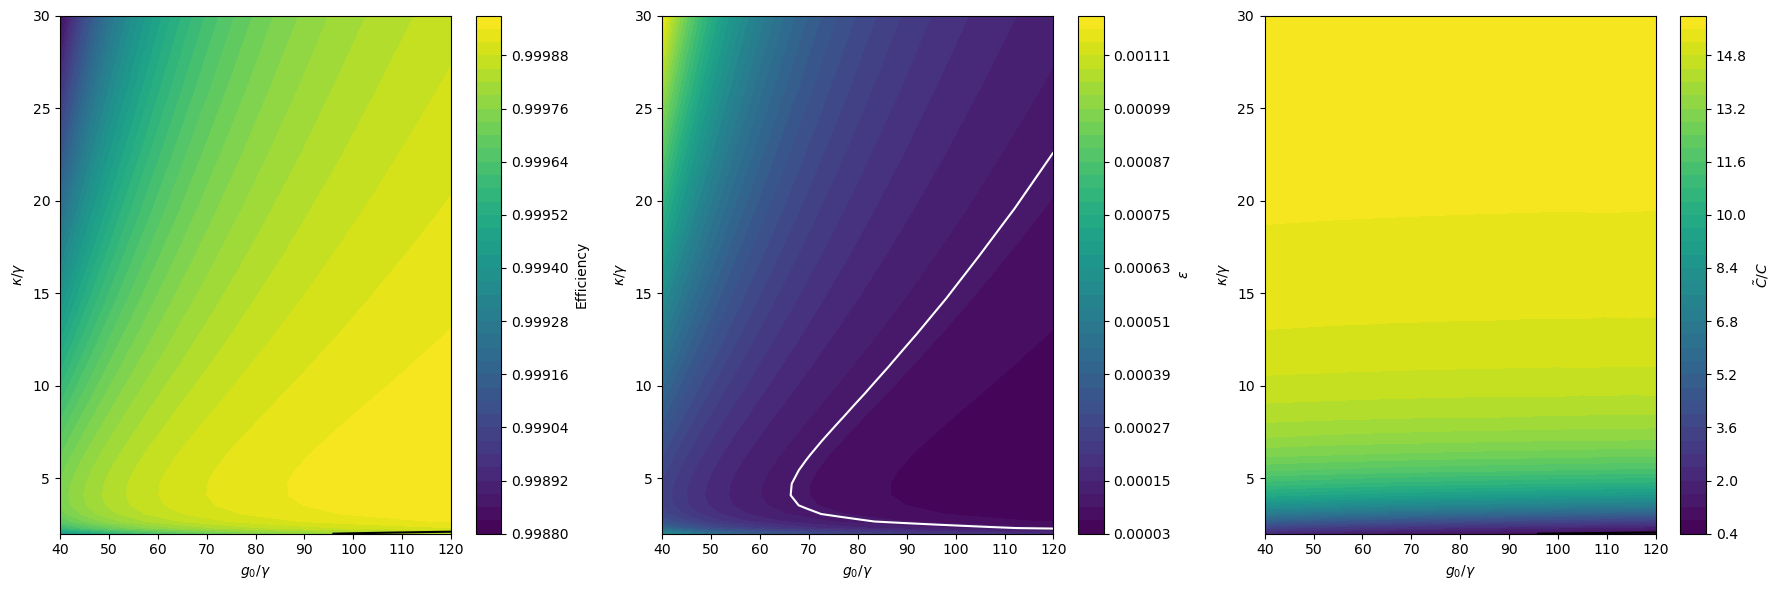

In [13]:
NUM_CONTS = 40
X,Y = np.meshgrid(g_ratios, kappas)

fig,[ax1,ax2,ax3] = plt.subplots(1,3)
fig.set_size_inches(18,6)

cp1=ax1.contourf(X,Y, effs, levels=NUM_CONTS)
cb1 = fig.colorbar(cp1)
cb1.set_label('Efficiency')
ax1.set_xlabel('$g_0/\gamma$')
ax1.set_ylabel('$\kappa/\gamma$')
cs1 = ax1.contour(X,Y, diff_effs, [0], colors='k')
#ax1.clabel(cs1, ['$2C/2C+1}$'])

cp2 = ax2.contourf(X,Y, errs, levels=NUM_CONTS)
cb2 = fig.colorbar(cp2)
cb2.set_label('$\epsilon$')
ax2.set_xlabel('$g_0/\gamma$')
ax2.set_ylabel('$\kappa/\gamma$')
cs2 = ax2.contour(X,Y, errs, [1e-4], colors='w')
#ax2.clabel(cs2, ['$\epsilon_{th}$'])

cp3 = ax3.contourf(X,Y, C_ratio, levels=NUM_CONTS)
cb3 = fig.colorbar(cp3)
cb3.set_label('$\\tilde{C}/C$')
ax3.set_xlabel('$g_0/\gamma$')
ax3.set_ylabel('$\kappa/\gamma$')
cs3 = ax3.contour(X,Y, C_ratio, [1], colors='k')
#ax3.clabel(cs3, ['1'])

fig.tight_layout()